In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets,transforms
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!nvidia-smi

Fri Jun 18 05:01:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2f36e4e7-fcd8-4c34-db67-cc9b10ce28b2)


In [5]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 460.32.03, 15109 MiB


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
transform=transforms.ToTensor()

In [8]:
train_data=datasets.MNIST(root="../content/Data",train=True,download=True,transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../content/Data/MNIST/raw/train-images-idx3-ubyte.gz to ../content/Data/MNIST/raw




Extracting ../content/Data/MNIST/raw/train-labels-idx1-ubyte.gz to ../content/Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../content/Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../content/Data/MNIST/raw




Extracting ../content/Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../content/Data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
test_data=datasets.MNIST(root="../content/Data",train=False,download=True,transform=transform)

In [10]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../content/Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [11]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../content/Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [14]:
train_loader=DataLoader(train_data,batch_size=5000,shuffle=True)
test_loader=DataLoader(test_data,batch_size=1000,shuffle=False)

In [15]:
# 1 color channel ,6 out channels, 3/3 kerner,1 stride(size)
conv1=nn.Conv2d(1,6,3,1)
conv2=nn.Conv2d(6,16,3,1)

In [16]:
for i,(x_train,y_train) in enumerate(train_data):
  break

In [17]:
x=x_train.view(1,1,28,28)

In [18]:
x=conv1(x)
x=f.relu(x)

In [19]:
x.shape

torch.Size([1, 6, 26, 26])

In [20]:
x=f.max_pool2d(x,2,2)

In [21]:
x.shape

torch.Size([1, 6, 13, 13])

In [22]:
x=conv2(x)

In [23]:
x=f.relu(x)

In [24]:
x.shape

torch.Size([1, 16, 11, 11])

In [25]:
x=f.max_pool2d(x,2,2)

In [26]:
x.shape

torch.Size([1, 16, 5, 5])

In [27]:
x=x.view(-1,16*5*5)

In [28]:
x.shape

torch.Size([1, 400])

In [29]:
class ConvolutionalNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1 = nn.Linear(5*5*16,120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,x):
    x=f.relu(self.conv1(x))
    x=f.max_pool2d(x,2,2)
    x=f.relu(self.conv2(x))
    x=f.max_pool2d(x,2,2)
    x=x.view(-1,5*5*16)
    x=f.relu(self.fc1(x))
    x=f.relu(self.fc2(x))
    x=self.fc3(x)
    return f.log_softmax(x,dim=1)

In [36]:
model=ConvolutionalNetwork()

In [37]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [38]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [39]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


In [40]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [41]:
import time
start_time = time.time()

epochs = 25
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
  trn_correct=0
  tst_correct=0
  for b,(x_train,y_train) in enumerate(train_loader):
    b+=1
    y_pred=model(x_train)
    loss=criterion(y_pred,y_train)
    predicted=torch.max(y_pred.data,1)[1]
    batch_correct=(predicted==y_train).sum()
    trn_correct+=batch_correct
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'epoch: {i:2}  batch: {b:4} [{5000*b:6}/60000]  loss: {loss.item():10.8f}  accuracy: {trn_correct.item()*100/(5000*b):7.3f}%')
    train_losses.append(loss)
    train_correct.append(trn_correct)
    with torch.no_grad():
        for b, (x_test, y_test) in enumerate(test_loader):
          y_val = model(x_test)
          predicted = torch.max(y_val.data, 1)[1] 
          tst_correct += (predicted == y_test).sum()
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_correct)
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  0  batch:    1 [  5000/60000]  loss: 2.30222535  accuracy:   8.860%
epoch:  0  batch:    2 [ 10000/60000]  loss: 2.29543996  accuracy:  11.930%
epoch:  0  batch:    3 [ 15000/60000]  loss: 2.28888965  accuracy:  13.733%
epoch:  0  batch:    4 [ 20000/60000]  loss: 2.28103781  accuracy:  15.880%
epoch:  0  batch:    5 [ 25000/60000]  loss: 2.27370882  accuracy:  17.528%
epoch:  0  batch:    6 [ 30000/60000]  loss: 2.26373506  accuracy:  18.897%
epoch:  0  batch:    7 [ 35000/60000]  loss: 2.25333142  accuracy:  20.743%
epoch:  0  batch:    8 [ 40000/60000]  loss: 2.24196959  accuracy:  22.725%
epoch:  0  batch:    9 [ 45000/60000]  loss: 2.22615099  accuracy:  25.160%
epoch:  0  batch:   10 [ 50000/60000]  loss: 2.21036601  accuracy:  27.632%
epoch:  0  batch:   11 [ 55000/60000]  loss: 2.19108844  accuracy:  30.144%
epoch:  0  batch:   12 [ 60000/60000]  loss: 2.17053437  accuracy:  32.533%
epoch:  1  batch:    1 [  5000/60000]  loss: 2.14512372  accuracy:  60.840%
epoch:  1  b

In [42]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [43]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 101    0    2    0    0    1    1    0    0    0]
 [   0  119    0    0    0    0    0    0    0    0]
 [   1    0   94    0    1    0    0    4    0    0]
 [   0    0    1  101    0    0    1    0    0    0]
 [   0    0    0    0   90    0    0    0    0    1]
 [   0    0    1    0    0   81    1    0    1    1]
 [   0    0    0    0    0    3   99    0    0    0]
 [   0    0    1    0    0    0    0  111    0    2]
 [   0    0    0    0    0    0    0    0   93    0]
 [   0    0    0    1    1    0    0    0    0   86]]


In [44]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
len(misses)

25

In [45]:
r = 12  
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [ 679  692  698  716  729  745  749  768]
Label: [   6    9    6    2    5    4    5    2]
Guess: [   3    7    5    3    6    2    6    0]


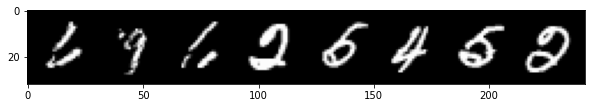

In [47]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = x_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))